# ONIOM Problem Decomposition - A use case for an acetic acid molecule in water

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/goodchemistryco/Tangelo/blob/develop/examples/oniom.ipynb)

## Table of contents:
* [1. Introduction](#1)
* [2. Use case - an acetic acid molecule in water](#2)
    * [2.1 Why is solvent interaction a relevant scientific problem?](#21)
    * [2.2 Why use ONIOM?](#22)
    * [2.3 How is it done?](#23)
    * [2.4 Potential energy scan for an hydrogen bond](#24)
* [3. Closing words](#3)


## 1. Introduction <a class="anchor" id="1"></a>
This notebook provides an overview of our implementation of the ONIOM method ([Chem. Rev. 2015, 115, 12, 5678–5796](https://pubs.acs.org/doi/10.1021/cr5004419)), a hybrid QM/MM technique. The ONIOM method enables the user to leverage the accuracy of computationally-expensive chemistry methods, only where expressly necessary, thus enabling us to investigate the applicability of quantum algorithms to more industrially-relevant problems.

When studying large molecules, and their interactions with other systems, the use of computationally-expensive techniques is often not only intractable, but also unnecessary. For example, when considering the interaction between a water molecule and a functional group appended to a large graphite flake, it is not reasonable to attempt to treat this entire system at the level of something like Full Configuration Interaction (FCI) or Coupled Cluster methods (ex: CCSD(T)). In such situations, the ONIOM method enables us to target the fragments of the problem at hand with the most sophisticated techniques we can afford, while relegating the rest of the problem to more affordable computational methods. This method can become particularly advantageous when we are interested in energy differences, where the contribution to the total molecular energy from the relatively inert volumes becomes negligible.

Formally, the energy evaluated by ONIOM (with a low- and high-accuracy methods) is expressed as:

$$E_{\text{ONIOM}} = E_{\text{All}}^{\text{Low}} + \sum_{i=1}^N (E_{\text{Fragment}_i}^{\text{High}} - E_{\text{Fragment}_i}^{\text{Low}})$$

Where $E_{\text{All}}$, $E_{\text{Fragment}_i}$ are respectively the energy of the whole system and the energy of a fragment labelled $i$. The general procedure for ONIOM is as follows. The user identifies a system of interest and a low-cost method is used to compute its total energy ($E_{\text{All}}^{\text{Low}}$). Subsequently, a subset of the molecule is defined as a model fragment and it is isolated by using an atom (or a functional group) to keep the valence shell fully populated. $E_{\text{Fragment}_i}^{\text{Low}}$ is computed for the fragment using the same low-cost method as used initially for the whole system, and a high-cost method ($E_{\text{Fragment}_i}^{\text{High}}$). The difference in energy between the high-cost and low-cost methods ($E_{\text{Fragment}_i}^{\text{High}} - E_{\text{Fragment}_i}^{\text{Low}}$) is then added to our total energy. This way, we can interpret the ONIOM method as an iterative procedure where the error associated with our low-cost solver is removed.

The equation above is formulated to allow us to expand ONIOM beyond a single fragment. In principle, many such fragments can be defined to progressively improve the accuracy or efficiency of the calculations. This may apply to when we have more than one active site on our large molecule, or where an incremental strategy can be utilized to further mitigate errors associated with using our low-cost method in the vicinity of our active region.

This notebook assumes that you already have installed Tangelo in your Python environment, or have updated your Python path so that the imports can be resolved. If not, executing the cell below installs the minimal requirements for this notebook.

In [1]:
# Installation of tangelo if not already installed.
try:
    import tangelo
except ModuleNotFoundError:
    !pip install git+https://github.com/goodchemistryco/Tangelo.git@develop --quiet

## 2. Use case - an acetic acid molecule in water<a class="anchor" id="2"></a>

### 2.1 Why are solvent interactions a relevant scientific problem?<a class="anchor" id="21"></a>

New technologies are in need of scientific insights on the interaction of molecules with a solvent. As illustrated below, many applications would benefit from these insights. The first example is the catalyst development for chemical reactions in liquids. Considering solvent molecules can improve the simulation accuracy, thus improving the acquired knowledge. Another predominant problem for water accessibility is its desalination. If a compound is able to selectively retain salt molecules and no other chemical entity, one could perform purification and thus convert saline water into potable water. Lastly, it is known that the solvent plays an important role to facilitate the protein-drug binding process. The accurate description of the solvent environment for the protein-ligand complex would give us a better understanding of the binding process, which could help us identify better drug candidates (more details can be found in section 9.1.1 of [Chem. Rev. 2015, 115, 12, 5678–5796](https://pubs.acs.org/doi/10.1021/cr5004419)).

![Solvation problems](img/solvation_problems.png "Solvation problems")

All of these problems can be approached from a bottom-up perspective, with numerical simulation from different angles. New discoveries are thus accelerated by insights provided by multiscale modeling. In the notebook, we tackle a specific case of an acetic acid molecule interaction with water using ONIOM.

### 2.2 Why use ONIOM? <a class="anchor" id="22"></a>

A single molecule can be positioned near a chemical group to identify the interaction force and optimal heteroatom-hydrogen distance. One can then decide to add more water molecules, for a more faithful modeling of the target use-case, thus disabling the hydrogen bond by stabilizing the relevant water molecule.

Even though the system size is very far from the thermodynamic limit, computational resources remain a constraint: using problem decomposition mitigates this issue. With the help of ONIOM, we can target a specific interaction to compute with a high-accuracy method, while considering an environment with a lower-cost electronic structure solver. This addition of a chemical environment can establish an easier link between simulation and experimental results, while keeping compute time practical.

### 2.3 How is it done? <a class="anchor" id="23"></a>

For the remaining part of this section, we will see how to combine the Variational Quantum Eigensolver (VQE) with Hartree-Fock (HF) to compute the ground state energy of a water/carboxylic acid system. We will focus our attention on the hydrogen bond between the COOH group and a water molecule, as seen in the figure below. The numbers on the right correspond to the selected atoms via their indices in the coordinates file. Internally, the `ONIOMProblemDecomposition` solver adds a hydrogen atom between atoms 0 and 1 to preserve the valence bond completeness.

<img src="img/ONIOM_example.png" width="700">

We want to specifically target the H2O-COOH interaction. We will use the Variational Quantum Eigensolver (VQE) with a Unitary Coupled-Cluster Single and Double excitation (UCCSD) ansatz. The basis set for this fragment is 6-31G(d,p). The rest of the system is simulated using Hartree-Fock (HF) with a minimal basis set (STO-3G).

First, we import the relevant dependencies:

In [2]:
from tangelo.problem_decomposition import ONIOMProblemDecomposition
from tangelo.problem_decomposition.oniom import Fragment, Link
from tangelo.algorithms import BuiltInAnsatze as Ansatze

The next thing to do is to define a geometry and some options for the desired solvers. As a side note, the quantum resources for this subsystem are still too demanding for Noisy Intermediate-Scale Quantum (NISQ) devices. We reduce the amount of resources by freezing molecular orbitals in the system: in our simple case, the fragment has been reduced to a HOMO-LUMO problem. This allows us to use UCC3 as the variational ansatz for VQE, as it is equivalent to UCCSD, but shallower (by removing redundant excitation terms) and can be applied to two-level systems. As progress is made in the development of more capable quantum devices, less agressive resource reduction could be chosen to increase the accuracy, at the cost of more challenging computation.

In [3]:
# Coordinates file
with open("xyz/water_system.xyz",'r') as f:
    xyz = f.read()
    # Removing first 2 lines (number of atoms and a comment line)
    xyz = xyz.split("\n", 2)[2]

options_low = {"basis": "sto-3g"}
options_high = {"basis": "6-31G**", 
                "qubit_mapping": "jw", 
                "ansatz": Ansatze.UCC3, 
                "up_then_down": True,
                "frozen_orbitals": [i for i in range(76) if i not in (16, 17)]}

In the next cell, we build the `ONIOMProblemDecomposition` object from a multi-line string taken from the coordinate file and `Fragment` objects. Moreover, in our case, a chemical bond is broken: a `Link` object is also defined by passing the atom ids defining the broken bond.

**Note**: The following cell may take a couple minutes to execute, as instantiating the `ONIOMProblemDecomposition` object in this situation involves HF calculations in the 6-31G** basis set.

In [4]:
# Whole system to be computed with a low-accuracy method (HF, sto-3g)
system = Fragment(solver_low="hf", options_low=options_low, charge=0)

# Fragment to be computed with a high-accuracy method (VQE-UCC3, 6-31G**).
links = [Link(0, 1, 0.709, 'H')]
model = Fragment(solver_low="hf", options_low=options_low,
                 solver_high="vqe", options_high=options_high,
                 selected_atoms=[1, 2, 3, 4, 8, 9, 10],
                 broken_links=links,
                 charge=0)

# Construction of the ONIOM solver.
oniom_solver = ONIOMProblemDecomposition({"geometry": xyz, "fragments": [system, model], "verbose": True})

We estimate the amount of quantum resources by calling the `get_resources` method (this does not require any simulation).

In [5]:
resources = oniom_solver.get_resources()

		Fragment Number : # 2 
		------------------------
		{'qubit_hamiltonian_terms': 27, 'circuit_width': 4, 'circuit_gates': 23, 'circuit_2qubit_gates': 8, 'circuit_var_gates': 3, 'vqe_variational_parameters': 3}



We call the `simulate` method to compute the ONIOM energy:

In [6]:
e_oniom = oniom_solver.simulate()
e_hf = oniom_solver.fragments[0].mol_low.mf_energy

print("ONIOM Energy: ", e_oniom)
print("Hartree-Fock Energy: ", e_hf)

ONIOM Energy:  -1278.2143431181937
Hartree-Fock Energy:  -1274.4936842154425


We can see that the ONIOM energy is in fact lower than the Hartree-Fock energy. However, we cannot compute the lower-bound energy for the entire system (VQE-UCCSD), as the computational requirements would be too high.

### 2.4 Potential energy scan for an hydrogen bond <a class="anchor" id="24"></a>

The ONIOM energy computed in the previous section can be difficult to compare with known validated data. In this case, we can compare the hydrogen bond distance with experimental results. One way of getting this distance is to perform an energy scan on many configurations. We varied the water molecule - carboxylic acid distance from 1.0 to 3.5 angstrom. An energy calculation, with the same parameters as in the previous section, was performed for each of these distances. The minimal energy point should correspond to the experimental hydrogen bond distance for this system.

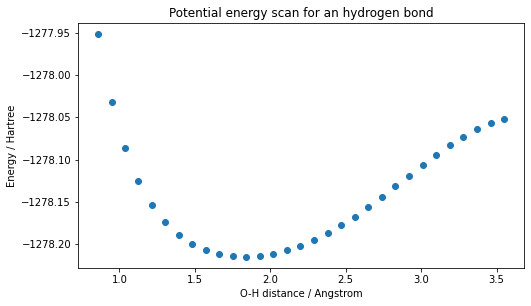

In [7]:
import matplotlib.pyplot as plt

distances = [3.550862922159438, 3.460762889964292, 3.370670305757595, 3.280585783157128, 3.1905100050249016, 3.1004437335081567, 3.0103878218778832, 2.9203432285513977, 2.8303110337833894, 2.740292459636501, 2.650288894007595, 2.5603019197028303, 2.4703333498422166, 2.3803852712588354, 2.29046009807724, 2.20056063836393, 2.1106901777200746, 2.020852585050676, 1.9310524476726847, 1.8412952456882081, 1.7515875795688893, 1.6619374708395822, 1.572354764687664, 1.4828516770284208, 1.3934435500122229, 1.3041499143311708, 1.214996013163829, 1.126015038057959, 1.0372514935327881, 0.9487664078760378, 0.8606456724847144]
energies = [-1278.051959731282, -1278.057229408819, -1278.0643608792661, -1278.073141506658, -1278.0833167826524, -1278.0945967737384, -1278.1066656511987, -1278.119193003125, -1278.1316621874737, -1278.1441348500723, -1278.1561527375766, -1278.1674486239667, -1278.1778145272128, -1278.1870878716404, -1278.1951499219097, -1278.201919599394, -1278.2073419570033, -1278.2113710433855, -1278.2139489568763, -1278.214985604411, -1278.2143431181898, -1278.21182121378, -1278.2071290776098, -1278.19982995337, -1278.1892617407693, -1278.1744445322772, -1278.153955355375, -1278.1257011700952, -1278.086488264795, -1278.0312418159333, -1277.95164876962]

plt.figure(figsize=(8,4.5))
plt.title("Potential energy scan for an hydrogen bond")
plt.xlabel("O-H distance / Angstrom")
plt.ylabel("Energy / Hartree")
plt.scatter(distances, energies)

The energy minimum corresponds to about 1.7 $\overset{\circ}{A}$ for the O-H distance. Hydrogen bond distances are known to be between 1.6 and 2.0 $\overset{\circ}{A}$ in bulk water ([Acta Cryst. 1976, A32, 24-31](https://scripts.iucr.org/cgi-bin/paper?a12816)), so this is in fact a plausible result. The bonding energy seems to be well beyond the one expected for a hydrogen bond. An explanation for this is that the simulation does not use the optimal geometry at each bond length to get accurate bonding energies.

## 3. Closing words<a class="anchor" id="3"></a>

In this notebook, a use-case simulation study has been introduced for a solvation problem. We learnt that the ONIOM problem decomposition method can be useful for studying more ambitious systems. This is done by targeting an important interaction in the system, thus allocating more computational (classical or quantum) resources to it. The environment (the remaining part), can be described with a lower-accuracy method. Therefore, a simple example has been presented as a potential starting point for a more complete research project.

Here we have used the ONIOM problem decomposition method as a way to investigate the applicability of quantum algorithms to more industrially-relevant problems. The results are in agreement with known experimental data.